In [3]:
%load_ext autoreload

In [4]:
%autoreload
import pygmsh
import numpy as np
import jax.numpy as jnp
from dctkit.mesh import util, simplex
from dctkit.math.opt import optctrl
from dctkit.physics.elasticity import LinearElasticity
import dctkit.dec.cochain as C
import dctkit as dt
from matplotlib.pyplot import triplot

In [5]:
dt.config()

In [6]:
lc = 0.5
L = 1.
with pygmsh.geo.Geometry() as geom:
    p = geom.add_polygon([[0., 0.], [L, 0.], [L, L], [0., L]], mesh_size=lc)
    # create a default physical group for the boundary lines
    geom.add_physical(p.lines, label="boundary")
    geom.add_physical(p.lines[0], label="down")
    geom.add_physical(p.lines[2], label="up")
    mesh = geom.generate_mesh()

S = util.build_complex_from_mesh(mesh)
S.get_hodge_star()
S.get_flat_DPD_weights()
S.get_flat_DPP_weights()

ref_node_coords = S.node_coords

In [7]:
down_bnd_nodes_idx = util.get_nodes_for_physical_group(mesh, 1, "down")
up_bnd_nodes_idx = util.get_nodes_for_physical_group(mesh, 1, "up")
down_bnd_edges_idx = util.get_edges_for_physical_group(S, mesh, "down")
up_bnd_edges_idx = util.get_edges_for_physical_group(S, mesh, "up")

print(down_bnd_edges_idx)
print(up_bnd_edges_idx)

[0, 3]
[7, 9]


In [8]:
mu_ = 1.
lambda_ = 10.
gamma_ = 0.2
true_curr_node_coords = S.node_coords.copy()
true_curr_node_coords[:, 0] += gamma_*S.node_coords[:, 1]
up_bnd_pos_components = [0]

up_bnd_nodes_pos_x = true_curr_node_coords[up_bnd_nodes_idx, up_bnd_pos_components]
up_bnd_nodes_pos_y = ref_node_coords[up_bnd_nodes_idx, 1]
down_bnd_pos = ref_node_coords[down_bnd_nodes_idx, :]

In [25]:
# NOTE: without flatten it does not work properly when concatenating multiple bcs;
# fix this so that flatten is not needed (not intuitive)
boundary_values = {"0": (up_bnd_nodes_idx, up_bnd_nodes_pos_x),
                   ":": (down_bnd_nodes_idx, down_bnd_pos)}
print(boundary_values)
ela = LinearElasticity(S=S, mu_=mu_, lambda_=lambda_)
gamma = 100000.
num_faces = S.S[2].shape[0]
embedded_dim = S.space_dim
f = np.zeros((num_faces, (embedded_dim-1)))
obj = ela.obj_linear_elasticity_energy
x0 = S.node_coords.flatten()

# traction bcs
idx_up_down_edges = up_bnd_edges_idx
print(idx_up_down_edges)
bnd_tractions_values = np.zeros(len(idx_up_down_edges), dtype=dt.float_dtype)
boundary_tractions = {'1': (idx_up_down_edges, bnd_tractions_values)}
obj_args = {'f': f, 'gamma': gamma, 'boundary_values': boundary_values}
#obj_args = {'f': f, 'gamma': gamma, 'boundary_values': boundary_values, 'boundary_tractions': boundary_tractions}

{'0': ([2, 3, 6], array([1.2, 0.2, 0.7])), ':': ([0, 1, 4], array([[0. , 0. , 0. ],
       [1. , 0. , 0. ],
       [0.5, 0. , 0. ]]))}
[7, 9]


In [26]:
prb = optctrl.OptimizationProblem(dim=len(x0), state_dim=len(x0),objfun=obj)

prb.set_obj_args(obj_args)
sol = prb.solve(x0=x0, ftol_abs=1e-9, ftol_rel=1e-9)
print(prb.last_opt_result)
curr_node_coords = sol.reshape(S.node_coords.shape)

1


In [27]:
strain = ela.get_infinitesimal_strain(curr_node_coords)
stress = ela.get_stress(strain)

print("strain=", strain)
print("stress=", stress)

strain= [[[ 4.18434556e-02  5.02704949e-02]
  [ 5.02704949e-02 -4.41292907e-02]]

 [[-6.93338250e-02  5.09599317e-02]
  [ 5.09599317e-02  9.40199276e-02]]

 [[-1.34242547e-06  5.60140118e-02]
  [ 5.60140118e-02  1.45792847e-02]]

 [[ 1.38622663e-06  5.21886656e-02]
  [ 5.21886656e-02 -7.05173128e-03]]

 [[ 1.42648465e-06  5.26809272e-02]
  [ 5.26809272e-02 -1.96705429e-02]]

 [[ 7.55121322e-02  4.98400955e-02]
  [ 4.98400955e-02 -1.00862912e-01]]

 [[-1.45238831e-06  6.43015409e-02]
  [ 6.43015409e-02  1.02567244e-02]]

 [[-2.24636732e-02  6.27304524e-02]
  [ 6.27304524e-02  2.95767684e-02]]

 [[ 4.31927235e-02  5.07631052e-02]
  [ 5.07631052e-02 -4.98104040e-02]]

 [[-4.58208735e-02  7.67361924e-02]
  [ 7.67361924e-02  3.70609284e-02]]

 [[-1.63087349e-02  7.50583212e-02]
  [ 7.50583212e-02  3.44622605e-02]]

 [[-5.99918876e-03  3.96020386e-02]
  [ 3.96020386e-02  4.30439661e-03]]

 [[ 2.36110231e-02  8.86279676e-02]
  [ 8.86279676e-02 -3.42649721e-02]]

 [[-1.73439586e-02  7.00335536

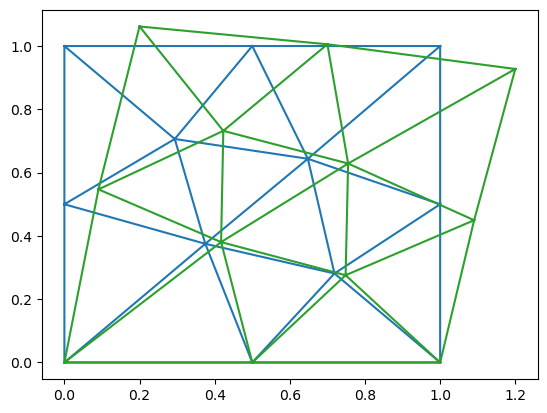

In [28]:
triplot(ref_node_coords[:,0], ref_node_coords[:,1], triangles=S.S[2])
triplot(curr_node_coords[:,0], curr_node_coords[:,1], triangles=S.S[2])


In [23]:
print(ela.obj_linear_elasticity_energy(curr_node_coords, f, gamma, boundary_values))
print(ela.obj_linear_elasticity_energy(true_curr_node_coords, f, gamma, boundary_values))
node_coords_coch = C.CochainP0(complex=S, coeffs=curr_node_coords)
f_coch = C.CochainP2(complex=S, coeffs=f)
elastic_energy = ela.elasticity_energy(node_coords_coch, f_coch)
print(elastic_energy)

0.039999999965143584
0.04000000000000001
0.039999999965143584


In [24]:
print(true_curr_node_coords)
print(curr_node_coords)

[[0.         0.         0.        ]
 [1.         0.         0.        ]
 [1.2        1.         0.        ]
 [0.2        1.         0.        ]
 [0.5        0.         0.        ]
 [1.1        0.5        0.        ]
 [0.7        1.         0.        ]
 [0.1        0.5        0.        ]
 [0.435      0.70625    0.        ]
 [0.45       0.375      0.        ]
 [0.77666667 0.64375    0.        ]
 [0.775      0.28125    0.        ]]
[[ 4.29800590e-16 -1.30525707e-15  0.00000000e+00]
 [ 1.00000000e+00 -6.22360043e-16  0.00000000e+00]
 [ 1.20000000e+00  1.00000000e+00  0.00000000e+00]
 [ 2.00000000e-01  1.00000000e+00  0.00000000e+00]
 [ 5.00000000e-01 -1.01081651e-15  0.00000000e+00]
 [ 1.10000000e+00  5.00000000e-01  0.00000000e+00]
 [ 7.00000000e-01  1.00000000e+00  0.00000000e+00]
 [ 1.00000000e-01  5.00000000e-01  0.00000000e+00]
 [ 4.35000000e-01  7.06250000e-01  0.00000000e+00]
 [ 4.50000000e-01  3.75000000e-01  0.00000000e+00]
 [ 7.76666667e-01  6.43750000e-01  0.00000000e+00]
 [ 7.7